# Chapter 9: Dealing with Few to No Labels
# Building a GitHub Issues Tagger

In [9]:
from collections import defaultdict
from datasets import Dataset, DatasetDict
import nlpaug.augmenter.word as naw
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pandas as pd
import pickle
from scipy.special import expit as sigmoid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import BinaryRelevance
import torch
import transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import pipeline

# p252, Preparing the Data

In [17]:
fname = 'ch09_dataset.pickle'
if os.path.exists(fname):
    df_issues = pickle.load(open(fname, 'rb'))
else:
    dataset_url = 'https://git.io/nlp-with-transformers'
    df_issues = pd.read_json(dataset_url, lines=True)
    pickle.dump(df_issues, open(fname, 'wb'))

print(f'DataFrame shape: {df_issues.shape}')

DataFrame shape: (9930, 26)


In [11]:
cols = ['url', 'id', 'title', 'user', 'labels', 'state', 'created_at', 'body']
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [12]:
df_issues.loc[2, 'labels']

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

In [18]:
df_issues['labels'] = (df_issues['labels']
                      .apply(lambda x: [meta['name'] for meta in x]))
df_issues[['labels']].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [19]:
df_issues['labels'].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [20]:
df_counts = df_issues['labels'].explode().value_counts()
print(f'Number of labels: {len(df_counts)}')
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [23]:
label_map = {
    'Core: Tokenization': 'tokenization',
    'New model': 'new model',
    'Core: Modeling': 'model training',
    'Usage': 'usage',
    'Core: Pipeline': 'pipeline',
    'TensorFlow': 'tensorflow or tf',
    'PyTorch': 'pytorch',
    'Examples': 'examples',
    'Documentation': 'documentation'
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues['labels'] = df_issues['labels'].apply(filter_labels)
all_labels = list(label_map.values())

df_counts = df_issues['labels'].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [24]:
df_issues['split'] = 'unlabeled'
mask = df_issues['labels'].apply(lambda x: len(x) > 0)
df_issues.loc[mask, 'split'] = 'labeled'
df_issues['split'].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [26]:
for column in ['title', 'body', 'labels']:
    print(f'{column}: {df_issues[column].iloc[26][:500]}\n')

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [27]:
df_issues['text'] = (df_issues
                    .apply(lambda x: x['title'] + '\n\n' + x['body'], axis=1))

In [29]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset='text')
print(f'Removed {(len_before - len(df_issues))/len_before:.2%} duplicates.')

Removed 1.88% duplicates.


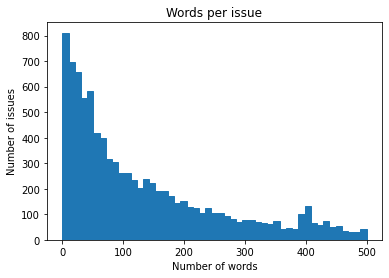

In [31]:
(df_issues['text'].str.split().apply(len)
  .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor='C0'))
plt.title('Words per issue')
plt.xlabel('Number of words')
plt.ylabel('Number of issues')
plt.show()

In [3]:
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([['tokenization', 'new model'], ['pytorch']])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [19]:
def balanced_split(mlb, df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df['labels'])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [20]:
df_clean = df_issues[['text', 'labels', 'split']].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean['split'] == 'unlabeled', ['text', 'labels']]
df_sup = df_clean.loc[df_clean['split'] == 'labeled', ['text', 'labels']]

np.random.seed(0)
df_train, df_tmp = balanced_split(mlb, df_sup, test_size=0.5)
df_valid, df_test = balanced_split(mlb, df_tmp, test_size=0.5)

In [38]:
ds = DatasetDict({
    'train': Dataset.from_pandas(df_train.reset_index(drop=True)),
    'valid': Dataset.from_pandas(df_valid.reset_index(drop=True)),
    'test': Dataset.from_pandas(df_test.reset_index(drop=True)),
    'unsup': Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

In [41]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds['train']))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds['train']['labels'])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k - last_k) / len(labels)
    )
    last_k = k
    if i == 0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))
        
# And full dataset as last slice
train_slices.append(all_indices)
train_samples.append(len(ds['train']))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [44]:
print('Target split sizes:')
print(train_samples)
print('Actual split sizes:')
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


# p260, Implementing a naive Bayesline

In [45]:
def prepare_labels(batch):
    batch['label_ids'] = mlb.transform(batch['labels'])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [74]:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [75]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds['train'].select(train_slice)  # [0 2 9 11 ...]
    y_train = np.array(ds_train_sample['label_ids'])  # [[0 0 0 1 ...] [0 0 0 1 ...] ...]
    y_test = np.array(ds['test']['label_ids'])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample['text'])  # Kx887 sparse matrix
    X_test_counts = count_vect.transform(ds['test']['text'])
    # Create and train our model
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names = mlb.classes_, zero_division=0,
        output_dict=True
    )
    # Store metrics
    macro_scores['Naive Bayes'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Naive Bayes'].append(clf_report['micro avg']['f1-score'])

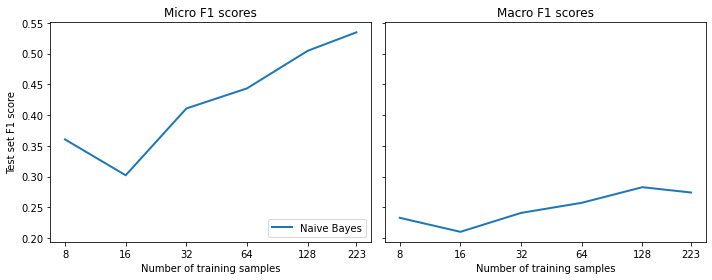

In [76]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    
    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle='dashed')
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle='dashed')
    
    ax0.set_title('Micro F1 scores')
    ax1.set_title('Macro F1 scores')
    ax0.set_ylabel('Test set F1 score')
    ax0.legend(loc='lower right')
    for ax in [ax0, ax1]:
        ax.set_xlabel('Number of training samples')
        ax.set_xscale('log')
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

plot_metrics(micro_scores, macro_scores, train_samples, 'Naive Bayes')

# p263, Working with No Labeled data

In [3]:
pipe = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
movie_desc = 'The main characters of the movie madacascar \
are lion, a zebra, a giraffe, and a hippo.'
prompt = 'The movie is about [MASK].'

output = pipe(movie_desc + prompt)
for element in output:
    print(f'Token {element["token_str"]}:\t{element["score"]:.3f}%')

Token lions:	0.154%
Token animals:	0.113%
Token birds:	0.027%
Token lion:	0.022%
Token tigers:	0.015%


In [8]:
output = pipe(movie_desc + prompt, targets=['animals', 'cars'])
for element in output:
    print(f'Token {element["token_str"]}:\t{element["score"]:.3f}%')

Token animals:	0.113%
Token cars:	0.000%


In [9]:
movie_desc = 'In the movie transformers aliens \
can morph into a wide range of vehicles.'

output = pipe(movie_desc + prompt, targets=['animals', 'cars'])
for element in output:
    print(f'Token {element["token_str"]}:\t{element["score"]:.3f}%')

Token cars:	0.139%
Token animals:	0.006%


In [11]:
pipe = pipeline('zero-shot-classification')

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [12]:
sample = ds['train'][0]
print(f'Labels: {sample["labels"]}')
output = pipe(sample['text'], all_labels, multi_label=True)
print(output['sequence'][:400])
print('\nPredictions:')

for label, score in zip(output['labels'], output['scores']):
    print(f'{label}, {score:2f}')

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.983889
tensorflow or tf, 0.365516
examples, 0.336445
usage, 0.296716
pytorch, 0.247813
documentation, 0.245003
model training, 0.235294
tokenization, 0.173724
pipeline, 0.160416


In [13]:
def zero_shot_pipeline(example):
    output = pipe(example['text'], all_labels, multi_label=True)
    example['predicted_labels'] = output['labels']
    example['scores'] = output['scores']
    return example

ds_zero_shot = ds['valid'].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

In [20]:
ds_zero_shot.to_pandas()[['labels', 'predicted_labels', 'scores']]

,labels,predicted_labels,scores
0,[new model],"[new model, pytorch, documentation, usage, pip...","[0.9883275628089905, 0.9305453896522522, 0.650..."
1,[new model],"[new model, tokenization, usage, pipeline, exa...","[0.9976766705513, 0.9910666346549988, 0.904705..."
2,[examples],"[examples, model training, tensorflow or tf, p...","[0.8797267079353333, 0.628290057182312, 0.4842..."
3,[new model],"[model training, new model, pipeline, usage, p...","[0.9517663717269897, 0.7793276309967041, 0.531..."
4,[pytorch],"[examples, pytorch, new model, usage, pipeline...","[0.5097230672836304, 0.47688230872154236, 0.39..."
...,...,...,...
101,[pipeline],"[examples, new model, tokenization, pipeline, ...","[0.79127436876297, 0.7870073914527893, 0.78086..."
102,[pipeline],"[new model, pipeline, usage, documentation, to...","[0.9309496879577637, 0.7411472797393799, 0.477..."
103,[pipeline],"[pipeline, new model, usage, pytorch, tensorfl...","[0.8765822649002075, 0.6607277989387512, 0.633..."
104,[pipeline],"[model training, new model, pipeline, examples...","[0.9900783896446228, 0.9346898198127747, 0.725..."


In [21]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example['predicted_labels'], example['scores']):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example['predicted_labels'][i])
    else:
        raise ValueError('Set either "threshold" or "topk"')
    return {'pred_label_ids': list(np.squeeze(mlb.transform([preds])))}

In [29]:
def get_clf_report(ds):
    y_true = np.array(ds['label_ids'])
    y_pred = np.array(ds['pred_label_ids'])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_,
        zero_division=0, output_dict=True
    )

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

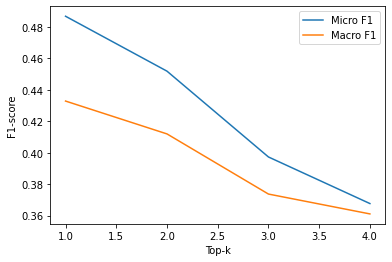

In [30]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])
    
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel('Top-k')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

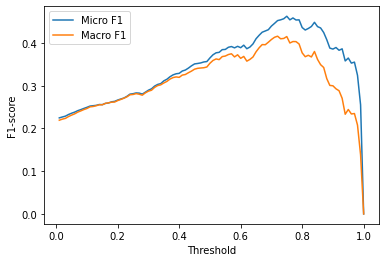

In [2]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'threshold': threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])
    
plt.plot(thresholds, micros, label='Micro F1')
plt.plot(thresholds, macros, label='Macro F1')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

In [3]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}')

Best threshold (micro): 0.75 with F1-score 0.46
Best threshold (macro): 0.72 with F1-score 0.42


In [ ]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})

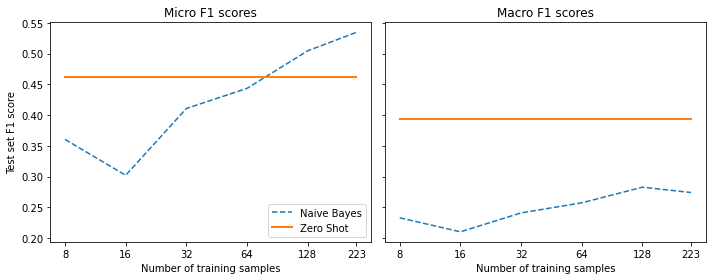

In [6]:
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
    
plot_metrics(micro_scores, macro_scores, train_samples, 'Zero Shot')

# p271, Data Augmentation

In [3]:
transformers.set_seed(3)
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', device='cpu', action='substitute'
)

text = 'Transformers are the most popular toys'
print(f'Original text: {text}')
print(f'Augmented text: {aug.augment(text)}')

Original text: Transformers are the most popular toys
Augmented text: ['transformers in the most relevant toys']


In [22]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch['text'], batch['label_ids']):
        # print('FIXME, input text:', text[:80], ', label ids:', label_ids)
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            cur_aug = aug.augment(text)
            # print('FIXME, cur aug:', cur_aug[:80])
            text_aug += cur_aug
            label_ids += [labels]
    # print('FIXME, text arr len:', len(text_aug), ', label ids:', label_ids)
    return {'text': text_aug, 'label_ids': label_ids}

In [23]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds['train'].select(train_slice)  # [0 2 9 11 ...]
    print(f'Augment a slice of length {len(train_slice)}')
    # ** Augment **
    ds_train_sample = ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names
    ).shuffle(seed=42)
    y_train = np.array(ds_train_sample['label_ids'])  # [[0 0 0 1 ...] [0 0 0 1 ...] ...]
    y_test = np.array(ds['test']['label_ids'])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample['text'])  # Kx887 sparse matrix
    X_test_counts = count_vect.transform(ds['test']['text'])
    # Create and train our model
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names = mlb.classes_, zero_division=0,
        output_dict=True
    )
    # Store metrics
    macro_scores['Naive Bayes + Aug'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Naive Bayes + Aug'].append(clf_report['micro avg']['f1-score'])

Augment a slice of length 10


  0%|          | 0/1 [00:00<?, ?ba/s]

Augment a slice of length 19


  0%|          | 0/1 [00:00<?, ?ba/s]

Augment a slice of length 36


  0%|          | 0/1 [00:00<?, ?ba/s]

Augment a slice of length 68


  0%|          | 0/1 [00:00<?, ?ba/s]

Augment a slice of length 134


  0%|          | 0/1 [00:00<?, ?ba/s]

Augment a slice of length 223


  0%|          | 0/1 [00:00<?, ?ba/s]

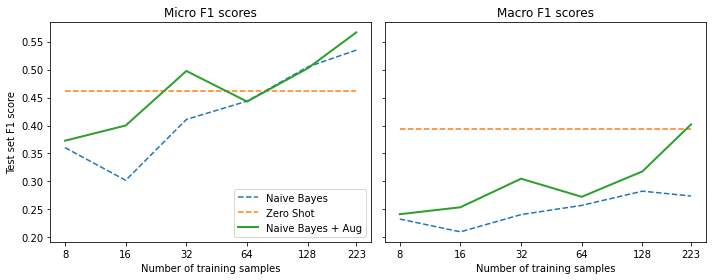

In [24]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Naive Bayes + Aug')

# p275, Using Embeddings as a Lookup Table

In [7]:
model_ckpt = 'miguelvictor/python-gpt2-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

tokenizer.pad_token = tokenizer.eos_token

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    # tensor([[ N vectors ]])
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)  # tensor([[1, 1, 1, 1]]) -> tensor([[[1], [1], [1], [1]]])
                           # torch.Size([batch_size, n_tokens, embedding_size])
                           # .expand: singleton dimension to a larger size:
                           #   tensor([[[1, 1, 1,  ..., 1, 1, 1], [1, 1, 1,  ..., 1, 1, 1], [1, 1, 1,  ..., 1, 1, 1], [1, 1, 1,  ..., 1, 1, 1]]])
                           #   tensor of torch.Size, all set to 1
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    # {'input_ids': tensor([[11246,  1672,   329,  1332]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
    inputs = tokenizer(examples['text'], padding=True, truncation=True,
                     max_length=128, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**inputs)  # BaseModelOutputWithPastAndCrossAttentions(...)
    pooled_embeds = mean_pooling(model_output, inputs['attention_mask'])
    return {'embedding': pooled_embeds.cpu().numpy()}

In [27]:
embs_train = ds['train'].map(embed_text, batched=True, batch_size=16)
embs_valid = ds['valid'].map(embed_text, batched=True, batch_size=16)
embs_test = ds['test'].map(embed_text, batched=True, batch_size=16)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [50]:
embs_train.add_faiss_index('embedding')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [53]:
l, k = 0, 3  # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n"  # Used to remove newlines in text for compact display

query = np.array(embs_valid[i]['embedding'], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples('embedding', query, k=k)

print(f'QUERY LABELS: {embs_valid[i]["labels"]}')
print(f'QUERY TEXT:\n{embs_valid[i]["text"][:200].replace(rn, nl)} [...]\n')
print('=' * 50)
print('Retrieved documents:')
for score, label, text in zip(scores, samples['labels'], samples['text']):
    print('=' * 50)
    print(f'TEXT:\n{text[:200].replace(rn, nl)} [...]')
    print(f'SCORE: {score:.2f}')
    print(f'LABELS: {label}')

QUERY LABELS: ['pytorch']
QUERY TEXT:
[Good first issue] DistilBERT PyTorch Integration tests

The PyTorch implementation of the DistilBERT model currently has no integration tests. This is problematic as the behavior can diverge without  [...]

Retrieved documents:
TEXT:
[Good first issue] DistilBERT TensorFlow Integration tests

The TensorFlow implementation of the DistilBERT model currently has no integration tests. This is problematic as the behavior can diverge wi [...]
SCORE: 5.38
LABELS: ['tensorflow or tf']
TEXT:
[Good first issue] ALBERT PyTorch Integration tests

The PyTorch implementation of the ALBERT model currently has no integration tests. This is problematic as the behavior can diverge without being no [...]
SCORE: 15.89
LABELS: ['pytorch']
TEXT:
[Good first issue] LXMERT PyTorch Integration tests

The PyTorch implementation of the LXMERT model currently has no integration tests. This is problematic as the behavior can diverge without being no [...]
SCORE: 20.15
LABELS:

In [77]:
def get_sample_preds(sample, m):
    # sample: dict with keys 'text', 'label_id'
    # each value: array of size 'topk'
    # in case of labels: it's a 1-hot vector
    return (np.sum(sample['label_ids'], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    # valid_queries: nparray shape: (n queries, embedding size)
    # valid_labels: nparray shape: (n queries, label as a vector)
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch('embedding', valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred, target_names=mlb.classes_,
                                              zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report['micro avg']['f1-score']
            perf_macro[k, m] = clf_report['macro avg']['f1-score']
    return perf_micro, perf_macro

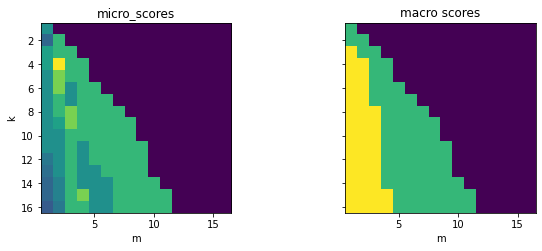

In [78]:
valid_labels = np.array(embs_valid.select([0, 1])['label_ids'])
valid_queries = np.array(embs_valid.select([0, 1])['embedding'], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title('micro_scores')
ax0.set_ylabel('k')
ax1.set_title('macro scores')
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 -0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel('m')
plt.show()

In [81]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f'Best k: {k}, best m: {m}')

Best k: 4, best m: 2


In [9]:
embs_train.drop_index('embedding')
test_labels = np.array(embs_test['label_ids'])
test_queries = np.array(embs_test['embedding'], dtype=np.float32)

for train_slice in train_slices:
    # Create a Faiss index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index('embedding')
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch(
        'embedding', test_queries, k=int(k)
    )
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(
        test_labels, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True
    )
    macro_scores['Embedding'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Embedding'].append(clf_report['micro avg']['f1-score'])
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

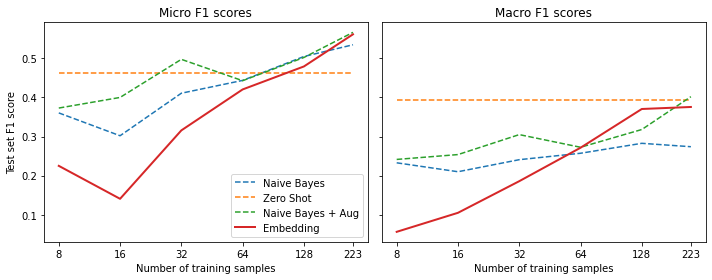

In [10]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Embedding')

# p284, Fine-Tuning a Vanilla Transformer

In [10]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [17]:
ds_enc.set_format('torch')
ds_enc = ds_enc.map(lambda x: {'label_ids_f': x['label_ids'].to(torch.float)},
                   remove_columns=['label_ids'])
ds_enc = ds_enc.rename_column('label_ids_f', 'label_ids')

  0%|          | 0/223 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/111 [00:00<?, ?ex/s]

  0%|          | 0/9303 [00:00<?, ?ex/s]

In [11]:
training_args_fine_tune = TrainingArguments(
    output_dir='./ch09_fine_tune', num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy='epoch', save_strategy='epoch', logging_strategy='epoch',
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error'
)

In [33]:
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred > 0.5).astype(float)
    
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                    zero_division=0, output_dict=True)
    return {'micro f1': clf_dict['micro avg']['f1-score'],
           'macro f1': clf_dict['macro avg']['f1-score'],}

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = 'multi_label_classification'

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
    
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc['train'].select(train_slice),
        eval_dataset=ds_enc['valid']
    )
    
    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    macro_scores['Fine-tune (vanilla)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (vanilla)'].append(metrics['micro f1'])

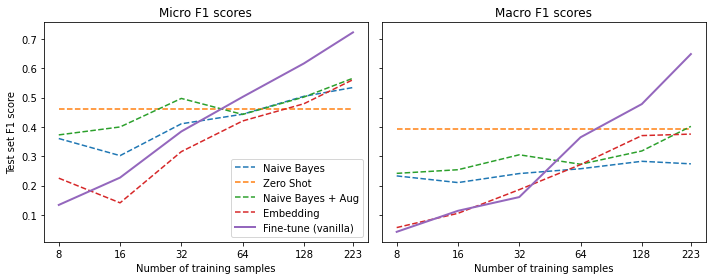

In [23]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Fine-tune (vanilla)')

# p289, Fine-Tuning a Language Model

In [24]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True,
                    max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(['labels', 'text', 'label_ids'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [26]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [38]:
transformers.set_seed(3)
data_collator.return_tensors = 'np'
inputs = tokenizer('Transformers are awesome!', return_tensors='np')
outputs = data_collator([{'input_ids': inputs['input_ids']}])

pd.DataFrame({
    'Original tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
    'Masked tokens': tokenizer.convert_ids_to_tokens(outputs['input_ids'][0][0]),
    'Original input_ids': inputs['input_ids'][0],
    'Masked input ids': outputs['input_ids'][0][0],
    'Labels': outputs['labels'][0][0]
}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[MASK]
Original input_ids,101,19081,2024,12476,999,102
Masked input ids,101,19081,2024,12476,103,103
Labels,-100,-100,-100,-100,999,102


In [39]:
data_collator.return_tensors = 'pt'

In [42]:
training_args = TrainingArguments(
    output_dir=f'{model_ckpt}-issues-128', per_device_eval_batch_size=32,
    logging_strategy='epoch', evaluation_strategy='epoch', save_strategy='no',
    num_train_epochs=16, push_to_hub=True, log_level='error', report_to='none'
)

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained('bert-base-uncased'),
    tokenizer=tokenizer, args=training_args, data_collator=data_collator,
    train_dataset=ds_mlm['unsup'], eval_dataset=ds_mlm['train']
)

trainer.train()

Cloning https://huggingface.co/olpa/bert-base-uncased-issues-128 into local empty directory.
/home/olpa/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.9863, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.5916668176651, 'eval_runtime': 22.4617, 'eval_samples_per_second': 9.928, 'eval_steps_per_second': 0.312, 'epoch': 1.0}
{'loss': 1.579, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.4667582511901855, 'eval_runtime': 22.5313, 'eval_samples_per_second': 9.897, 'eval_steps_per_second': 0.311, 'epoch': 2.0}
{'loss': 1.4305, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.394714117050171, 'eval_runtime': 22.6681, 'eval_samples_per_second': 9.838, 'eval_steps_per_second': 0.309, 'epoch': 3.0}
{'loss': 1.3367, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.2889429330825806, 'eval_runtime': 22.7177, 'eval_samples_per_second': 9.816, 'eval_steps_per_second': 0.308, 'epoch': 4.0}
{'loss': 1.2748, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.3376905918121338, 'eval_runtime': 22.7181, 'eval_samples_per_second': 9.816, 'eval_steps_per_second': 0.308, '

TrainOutput(global_step=18608, training_loss=1.1938592479440127, metrics={'train_runtime': 57001.3359, 'train_samples_per_second': 2.611, 'train_steps_per_second': 0.326, 'train_loss': 1.1938592479440127, 'epoch': 16.0})

In [44]:
trainer.push_to_hub('Training complete!')

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/olpa/bert-base-uncased-issues-128
   21a7835..cb882cf  main -> main



In [16]:
# Skip: print loss diagram: session was killed and `trainer` was lost

# p293, Fine-Tuning a Classifier

In [17]:
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_Labels = len(all_labels)
config.problem_type = 'multi_label_classification'

In [ ]:
# The rest went wrong, but I don't want to investigate why

In [ ]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
    
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc['train'].select(train_slice),
        eval_dataset=ds_enc['valid']
    )
    
    print('*** FIXME trainer:', trainer)
    
    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(äpre)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])